P(accept) = 0.8143466666666667
<x>       = -0.0010579398908569736
<xx>      = 0.49873736202766694


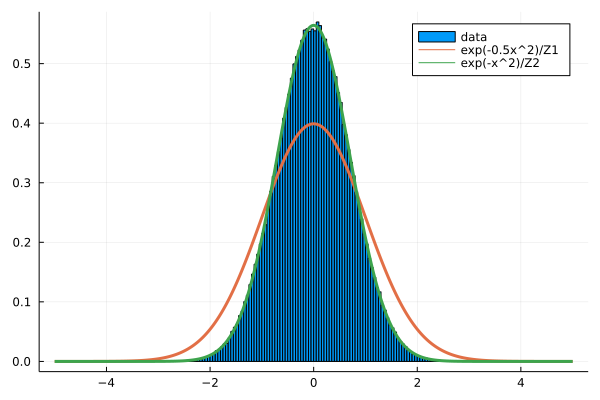

In [8]:
using Plots
using Random
using Distributions
using QuadGK

#============関数定義============================================#
function action(x)
    0.5*x*x
end

function deriv_action(x)
    x
end

function hamiltonian(x,p)
    action(x) + 0.5*p*p
end

function HMC_update(x,Nt,dt)
    #backup
    x_old = x
    p     = rand(Normal(0,1))
    
    #check
    H_ini = hamiltonian(x,p)
    x     = molecular_dynamics!(x,p,Nt,dt)
    H_fin = hamiltonian(x,p)
    
    r  = rand()
    ΔH = H_fin-H_ini
    if r < exp(-ΔH)
        return x,1 #accept
    else 
        return x_old,0
    end  
end

function molecular_dynamics!(x,p,Nt,dt) 
    force = 0.0
    #1/2step
        x = x + p * 0.5*dt
    #1~Nt-1 step
        for j=1:(Nt-1)
            force = deriv_action(x)
            p = p - dt * force
            x = x + dt * p
        end
    #Nt step
        p = p - dt * deriv_action(x)
        x = x + 0.5 * dt * p
        return x
end
#============関数終わり============================================#

#============計算=========================================================================#
  #セットアップ
    Ntest        = 300000
    Nt           = 20
    dt           = 1.0/Nt
    conf_vec     = zeros(Ntest)
    accept_count = 0
    ret          = 0
    x            = 0.0

    sumxx        = 0.0
    sumx         = 0.0

  #計算
    for i=1:Ntest
        x,ret         = HMC_update(x,Nt,dt)
        accept_count += ret
        conf_vec[i]   = x
    
        sumx         += x
        sumxx        += x*x
    end

    println("P(accept) = $(accept_count/Ntest)")
    println("<x>       = $(sumx/Ntest)")
    println("<xx>      = $(sumxx/Ntest)")

#=======確認=============================================================================#
    xr = range(-5,5,length=1000)
    f1(x) = exp(-0.5*x^2)
    f2(x) = exp(-x^2)
    Z1,error1 = quadgk(f1,-Inf,Inf)
    Z2,error2 = quadgk(f2,-Inf,Inf)
    g1(x) = f1(x)/Z1
    g2(x) = f2(x)/Z2
    histogram(conf_vec,norm=:true,label="data")
    plot!(xr,[g1.(xr) g2.(xr)],lw=3,label=["exp(-0.5x^2)/Z1" "exp(-x^2)/Z2"])
#========================================================================================#
